In [180]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import svm

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.inspection import DecisionBoundaryDisplay

# Read the data
results = pd.read_csv('results.csv', delimiter=',') 
results_UC = pd.read_csv('unit_comitment.csv', delimiter=',')

In [4]:
results.head()

,hour,generation 1,generation 2,generation 3,wind generation 1,wind generation 2,load 1,load 2,load 3,epsilon 1,...,transmission_up_binding_L3,transmission_down_binding_L3,transmission_up_binding_L4,transmission_down_binding_L4,transmission_up_binding_L5,transmission_down_binding_L5,transmission_up_binding_L6,transmission_down_binding_L6,transmission_up_binding_L7,transmission_down_binding_L7
0,0,100.0,0.0,10.000000,0.0,5.044859,7.190304,57.522429,50.332126,0.0,...,False,False,False,False,False,False,False,False,False,False
1,1,100.0,0.0,10.000000,0.0,7.889218,7.368076,58.944609,51.576533,0.0,...,False,False,False,False,False,False,False,False,False,False
2,2,100.0,0.0,10.000000,0.0,12.197143,7.637321,61.098571,53.461250,0.0,...,False,False,False,False,False,False,False,False,False,False
3,3,100.0,0.0,10.000000,0.0,5.828420,7.239276,57.914210,50.674934,0.0,...,False,False,False,False,False,False,False,False,False,False
4,4,100.0,0.0,11.403747,0.0,18.951910,8.147229,65.177829,57.030600,0.0,...,True,False,False,False,False,False,False,False,False,False


#### Features

In [38]:
# Check if units are always ON or OFF
y_train = results_UC[["G1","G2","G3"]]
print(y_train.mean())

# Filter out units that are always ON or OFF
units_to_classify = y_train.columns[(y_train.mean() > 0) & (y_train.mean() < 1)]
print(f"Units to classify: {units_to_classify}")

G1    1.000000
G2    0.275833
G3    0.962917
dtype: float64
Units to classify: Index(['G2', 'G3'], dtype='object')


In [48]:
features = results[['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3']]
targets = results_UC[['G2', 'G3']]

# Standardize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Shape
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1920, 5) (480, 5) (1920, 2) (480, 2)


**SMOTE = Synthetic Minority Oversampling Technique**

In [50]:
# Convert from multi-label to one label for SMOTE
y_train_G2 = y_train["G2"]
y_train_G3 = y_train["G3"]
y_test_G2 = y_test["G2"]
y_test_G3 = y_test["G3"]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled_G2, y_resampled_G2 = smote.fit_resample(X_train, y_train_G2)
X_resampled_G3, y_resampled_G3 = smote.fit_resample(X_train, y_train_G3)

# Check class distribution after resampling
from collections import Counter
print("Before SMOTE:", Counter(y_train_G2))
print("After SMOTE:", Counter(y_resampled_G2))
print("Mean after SMOTE:", y_resampled_G2.mean())
print("-"*50)
print("Before SMOTE:", Counter(y_train_G3))
print("After SMOTE:", Counter(y_resampled_G3))
print("Mean after SMOTE:", y_resampled_G3.mean())

Before SMOTE: Counter({0.0: 1390, 1.0: 530})
After SMOTE: Counter({0.0: 1390, 1.0: 1390})
Mean after SMOTE: 0.5
--------------------------------------------------
Before SMOTE: Counter({1.0: 1852, 0.0: 68})
After SMOTE: Counter({1.0: 1852, 0.0: 1852})
Mean after SMOTE: 0.5


### Logistic Regression

##### LogReg with SMOTE

Try LogReg with original UCs:

In [58]:
# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train_G2)

# Evaluate
y_pred = log_reg.predict(X_test)
print("Logistic Regression G2:") 
print(classification_report(y_test_G2, y_pred))

# Logistic Regression
log_reg.fit(X_train, y_train_G3)

# Evaluate
y_pred = log_reg.predict(X_test)
print("Logistic Regression G3:") 
print(classification_report(y_test_G3, y_pred))

Logistic Regression G2:
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       348
         1.0       0.82      0.85      0.83       132

    accuracy                           0.91       480
   macro avg       0.88      0.89      0.88       480
weighted avg       0.91      0.91      0.91       480

Logistic Regression G3:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        21
         1.0       1.00      1.00      1.00       459

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



Try LogReg with resampled UCs:

In [59]:
# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_resampled_G2, y_resampled_G2)

# Evaluate
y_pred = log_reg.predict(X_test)
print(classification_report(y_test_G2, y_pred))

# Logistic Regression
log_reg.fit(X_resampled_G3, y_resampled_G3)

# Evaluate
y_pred = log_reg.predict(X_test)
print(classification_report(y_test_G3, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91       348
         1.0       0.72      0.90      0.80       132

    accuracy                           0.88       480
   macro avg       0.84      0.88      0.86       480
weighted avg       0.89      0.88      0.88       480

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        21
         1.0       1.00      1.00      1.00       459

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



##### LogReg with class weights

In [60]:
# Define logistic regression models for each generator
logistic_models = {}

# Loop through each generator in the labels
for unit in units_to_classify:  # e.g., 'G1', 'G2', 'G3'
    print(f"\nTraining Logistic Regression for {unit}...")

    # Extract training and validation data for this unit
    y_train_unit = y_train[unit]
    y_test_unit = y_test[unit]

    # Initialize and train the logistic regression model
    logistic = LogisticRegression(class_weight="balanced", random_state=42)
    logistic.fit(X_train, y_train_unit)
    logistic_models[unit] = logistic

    # Predict on validation set
    y_pred = logistic.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test_unit, y_pred)
    print(f"Validation Accuracy for {unit}: {accuracy}")
    print(classification_report(y_test_unit, y_pred))



Training Logistic Regression for G2...
Validation Accuracy for G2: 0.8791666666666667
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91       348
         1.0       0.73      0.90      0.80       132

    accuracy                           0.88       480
   macro avg       0.84      0.89      0.86       480
weighted avg       0.89      0.88      0.88       480


Training Logistic Regression for G3...
Validation Accuracy for G3: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        21
         1.0       1.00      1.00      1.00       459

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



##### LogReg with adjusted decision threshold

Testing of threshold 0.10 - 0.95:

In [71]:
# Define logistic regression models for G2 and G3
logistic_models = {}
best_thresholds = {}

# Loop through G2 and G3
for unit in ['G2', 'G3']:
    print(f"\nTraining Logistic Regression for {unit}...")

    # Extract training and validation data for this unit
    y_train_unit = y_train[unit]
    y_test_unit = y_test[unit]

    # Initialize and train the logistic regression model
    logistic = LogisticRegression(class_weight="balanced", random_state=42)
    logistic.fit(X_train, y_train_unit)
    logistic_models[unit] = logistic

    # Predict probabilities on the test set
    y_probs = logistic.predict_proba(X_test)[:, 1]  # Probabilities for class 1

    # Fine-tune the threshold
    thresholds = [i / 100 for i in range(10, 100, 5)]  # Test thresholds from 0.1 to 0.95
    best_f1 = 0
    best_threshold = 0.5

    print(f"Fine-tuning threshold for {unit}...")
    for threshold in thresholds:
        # Apply the threshold
        y_pred_threshold = (y_probs >= threshold).astype(int)
        
        # Calculate F1-score
        f1 = f1_score(y_test_unit, y_pred_threshold)
        print(f"Threshold: {threshold:.2f}, F1-Score: {f1:.4f}")

        # Update the best threshold based on F1-score
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Store the best threshold for this unit
    best_thresholds[unit] = best_threshold
    print(f"Best Threshold for {unit}: {best_threshold:.2f}, Best F1-Score: {best_f1:.4f}")

    # Apply the best threshold for final predictions
    y_pred_best = (y_probs >= best_threshold).astype(int)

    # Evaluate performance with the best threshold
    accuracy = accuracy_score(y_test_unit, y_pred_best)
    print(f"Validation Accuracy for {unit} with best threshold {best_threshold}: {accuracy}")
    print(classification_report(y_test_unit, y_pred_best))

print("\nBest Thresholds:", best_thresholds)


Training Logistic Regression for G2...
Fine-tuning threshold for G2...
Threshold: 0.10, F1-Score: 0.7116
Threshold: 0.15, F1-Score: 0.7437
Threshold: 0.20, F1-Score: 0.7633
Threshold: 0.25, F1-Score: 0.7805
Threshold: 0.30, F1-Score: 0.7913
Threshold: 0.35, F1-Score: 0.8025
Threshold: 0.40, F1-Score: 0.7934
Threshold: 0.45, F1-Score: 0.8027
Threshold: 0.50, F1-Score: 0.8041
Threshold: 0.55, F1-Score: 0.8110
Threshold: 0.60, F1-Score: 0.8252
Threshold: 0.65, F1-Score: 0.8357
Threshold: 0.70, F1-Score: 0.8339
Threshold: 0.75, F1-Score: 0.8199
Threshold: 0.80, F1-Score: 0.7920
Threshold: 0.85, F1-Score: 0.7778
Threshold: 0.90, F1-Score: 0.7222
Threshold: 0.95, F1-Score: 0.6327
Best Threshold for G2: 0.65, Best F1-Score: 0.8357
Validation Accuracy for G2 with best threshold 0.65: 0.9041666666666667
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       348
         1.0       0.79      0.89      0.84       132

    accuracy                 

LogReg with interesting thresholds:

In [74]:
# Define logistic regression models for each generator
logistic_models = {}

# Define specific thresholds for G2 and G3
thresholds = {'G2': 0.65, 'G3': 0.75}

# Loop through each generator in the labels
for unit in units_to_classify:  # e.g., 'G2', 'G3'
    print(f"\nTraining Logistic Regression for {unit}...")

    # Extract training and validation data for this unit
    y_train_unit = y_train[unit]
    y_test_unit = y_test[unit]

    # Initialize and train the logistic regression model
    logistic = LogisticRegression(class_weight="balanced", random_state=42)
    logistic.fit(X_train, y_train_unit)
    logistic_models[unit] = logistic

    # Predict probabilities on the test set
    y_probs = logistic.predict_proba(X_test)[:, 1]  # Probabilities for class 1

    # Apply the adjusted threshold
    threshold = thresholds[unit]
    y_pred_threshold = (y_probs >= threshold).astype(int)

    # Evaluate performance with the adjusted threshold
    accuracy = accuracy_score(y_test_unit, y_pred_threshold)
    print(f"Validation Accuracy for {unit} with threshold {threshold}: {accuracy}")
    print(classification_report(y_test_unit, y_pred_threshold))



Training Logistic Regression for G2...
Validation Accuracy for G2 with threshold 0.65: 0.9041666666666667
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       348
         1.0       0.79      0.89      0.84       132

    accuracy                           0.90       480
   macro avg       0.87      0.90      0.88       480
weighted avg       0.91      0.90      0.91       480


Training Logistic Regression for G3...
Validation Accuracy for G3 with threshold 0.75: 0.975
              precision    recall  f1-score   support

         0.0       0.64      1.00      0.78        21
         1.0       1.00      0.97      0.99       459

    accuracy                           0.97       480
   macro avg       0.82      0.99      0.88       480
weighted avg       0.98      0.97      0.98       480



### Linear Kernel SVM

In [77]:
# Define SVM models for each generator
svm_models = {}

# Loop through each generator in the labels
for unit in units_to_classify:  # e.g., 'G1', 'G2', 'G3'
    print(f"\nTraining SVM (Linear Kernel) for {unit}...")

    # Extract training and validation data for this unit
    y_train_unit = y_train[unit]
    y_test_unit = y_test[unit]

    # Initialize and train the SVM model
    svm = SVC(kernel='linear', random_state=42)
    svm.fit(X_train, y_train_unit)
    svm_models[unit] = svm

    # Predict on validation set
    y_pred = svm.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test_unit, y_pred)
    print(f"Validation Accuracy for {unit}: {accuracy}")
    print(classification_report(y_test_unit, y_pred))



Training SVM (Linear Kernel) for G2...
Validation Accuracy for G2: 0.90625
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94       348
         1.0       0.83      0.83      0.83       132

    accuracy                           0.91       480
   macro avg       0.88      0.88      0.88       480
weighted avg       0.91      0.91      0.91       480


Training SVM (Linear Kernel) for G3...
Validation Accuracy for G3: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        21
         1.0       1.00      1.00      1.00       459

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



### RBF Kernel SVM (Non-linear)

In [78]:
# Define SVM models for each generator
svm_models = {}

# Loop through each generator in the labels
for unit in units_to_classify:  # e.g., 'G1', 'G2', 'G3'
    print(f"\nTraining SVM (RBF Kernel) for {unit}...")

    # Extract training and validation data for this unit
    y_train_unit = y_train[unit]
    y_test_unit = y_test[unit]

    # Initialize and train the SVM model
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train, y_train_unit)
    svm_models[unit] = svm

    # Predict on validation set
    y_pred = svm.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test_unit, y_pred)
    print(f"Validation Accuracy for {unit}: {accuracy}")
    print(classification_report(y_test_unit, y_pred))



Training SVM (RBF Kernel) for G2...
Validation Accuracy for G2: 0.9395833333333333
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       348
         1.0       0.89      0.89      0.89       132

    accuracy                           0.94       480
   macro avg       0.93      0.92      0.92       480
weighted avg       0.94      0.94      0.94       480


Training SVM (RBF Kernel) for G3...
Validation Accuracy for G3: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        21
         1.0       1.00      1.00      1.00       459

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



### Selection of 2/3 features + SVM

##### 2-D Plot

In [176]:
# # PCA with 2 components for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

# Split X_pca for training and testing
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, targets, test_size=0.2, random_state=42)

# Explained Variance
print("Explained Variance of the components:", pca.explained_variance_ratio_)
print(f"Total Explained Variance: {sum(pca.explained_variance_ratio_):.4f}")

# ####################################################################################
# print("-"*50)
#  # Define SVM models for each generator
# svm_models = {}

# # Loop through each generator in the labels
# for unit in units_to_classify:  # e.g., 'G1', 'G2', 'G3'
#     print(f"\nTraining SVM (Linear Kernel) for {unit}...")

#     # Extract training and validation data for this unit
#     y_train_unit = y_train[unit]
#     y_test_unit = y_test[unit]

#     # Initialize and train the SVM model
#     svm = SVC(kernel='linear', random_state=42)
#     svm.fit(X_train_pca, y_train_unit)
#     svm_models[unit] = svm

#     # Predict on validation set
#     y_pred = svm.predict(X_test_pca)

#     # Evaluate performance
#     accuracy = accuracy_score(y_test_unit, y_pred)
#     print(f"Validation Accuracy for {unit}: {accuracy}")
#     print(classification_report(y_test_unit, y_pred))

Explained Variance of the components: [0.74111999 0.19443254]
Total Explained Variance: 0.9356


In [212]:
def plot_decision_boundary_multi(
    kernel, X_train, y_train, X_test=None, y_test=None, 
    labels=None, classification=True, support_vectors=True, test=False):
    """
    Plot decision boundaries and classification reports for multi-label data.

    Parameters:
    - kernel: Kernel type for SVC.
    - X_train: Training feature data (2D for plotting).
    - y_train: Training target data (DataFrame or dict-like structure).
    - X_test: Test feature data (optional, used if test=True).
    - y_test: Test target data (optional, used if test=True).
    - labels: List of labels to plot and analyze (e.g., ["G2", "G3"]).
    - classification: Whether to print classification reports.
    - support_vectors: Whether to plot support vectors.
    - test: If True, plots and reports are generated for test data.
    """
    # Select data for plotting
    X = X_test if test else X_train
    y = y_test if test else y_train

    if labels is None:
        labels = y.columns  # Use all columns in y if no labels are provided

    # Create subplots
    num_labels = len(labels)
    fig, axes = plt.subplots(1, num_labels, figsize=(8 * num_labels, 5))

    # Ensure axes is iterable
    if num_labels == 1:
        axes = [axes]

    for i, label in enumerate(labels):
        # Train the SVC for the current label
        clf = SVC(kernel=kernel, gamma=1).fit(X_train, y_train[label])
        y_pred = clf.predict(X)

        # Print classification report
        if classification:
            print(f"Classification Report for {label} ({'Test' if test else 'Train'} Data):")
            print(classification_report(y[label], y_pred))

        # Plot decision boundary and margins
        ax = axes[i]
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

        common_params = {"estimator": clf, "X": X, "ax": ax}
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="predict",
            plot_method="pcolormesh",
            alpha=0.3,
        )
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="decision_function",
            plot_method="contour",
            levels=[-1, 0, 1],
            colors=["k", "k", "k"],
            linestyles=["--", "-", "--"],
        )

        if support_vectors:
            # Plot bigger circles around samples that serve as support vectors
            ax.scatter(
                clf.support_vectors_[:, 0],
                clf.support_vectors_[:, 1],
                s=150,
                facecolors="none",
                edgecolors="k",
            )

        # Plot samples by color and add legend
        scatter = ax.scatter(
            X[:, 0], X[:, 1], c=y[label], s=30, edgecolors="k", cmap="coolwarm"
        )
        ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
        ax.set_title(f"{label}: Decision boundaries of {kernel} kernel in SVC ({'Test' if test else 'Train'} Data)")

    plt.tight_layout()
    plt.show()


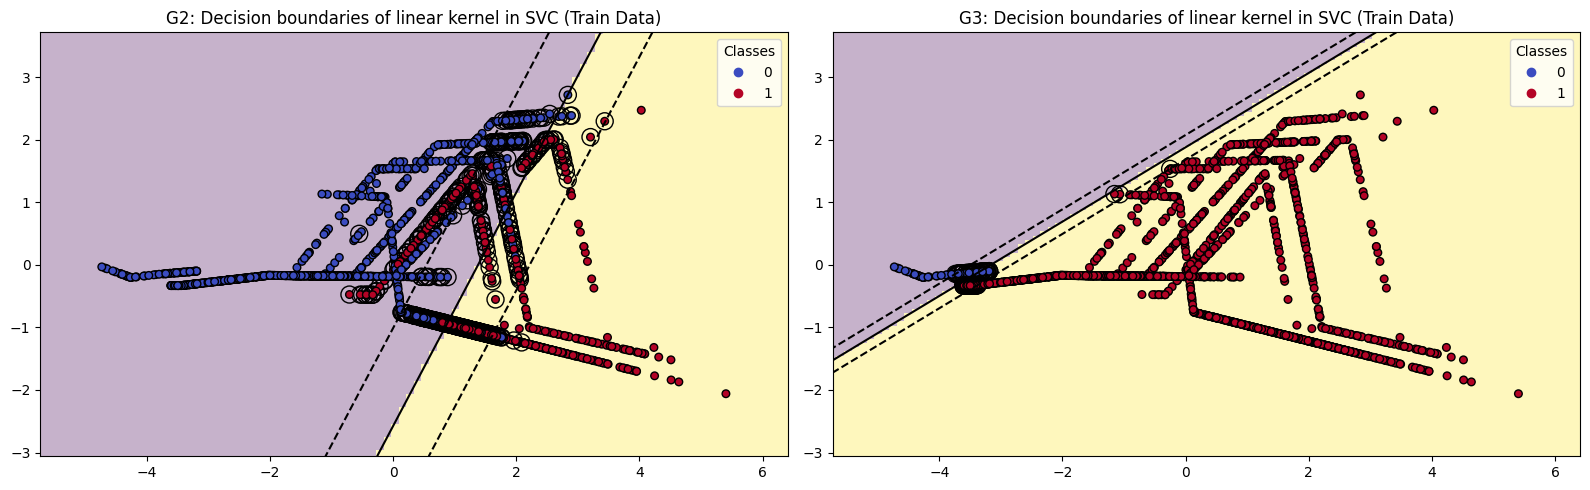

In [214]:
plot_decision_boundary_multi(kernel="linear", X_train=X_train_pca, y_train=y_train, classification=False)

##### Test Alternatives to PCA

t-SNE (t-distributed Stochastic Neighbor Embedding)

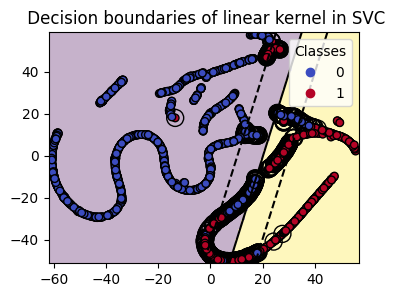

In [160]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(features)

# Use X_tsne for training and testing
X_train_tsne, X_test_tsne, y_train, y_test = train_test_split(X_tsne, targets, test_size=0.2, random_state=42)

# Plot with t-SNE-transformed data
plot_training_data_with_decision_boundary(kernel="linear", X=X_train_tsne, y=y_train["G2"])


Kernel PCA

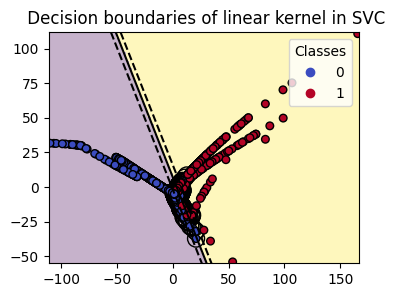

In [165]:
from sklearn.decomposition import KernelPCA

# Apply Kernel PCA with RBF kernel
kpca = KernelPCA(n_components=2, kernel='poly', gamma=1)
X_kpca = kpca.fit_transform(features)

# Use X_kpca for training and testing
X_train_kpca, X_test_kpca, y_train, y_test = train_test_split(X_kpca, targets, test_size=0.2, random_state=42)

# Use X_kpca for visualization
plot_training_data_with_decision_boundary(kernel="linear", X=X_train_kpca, y=y_train["G2"])

UMAP (Uniform Manifold Approximation and Projection)

In [ ]:
 # Copy features
features_new = features.copy()

# Add new features

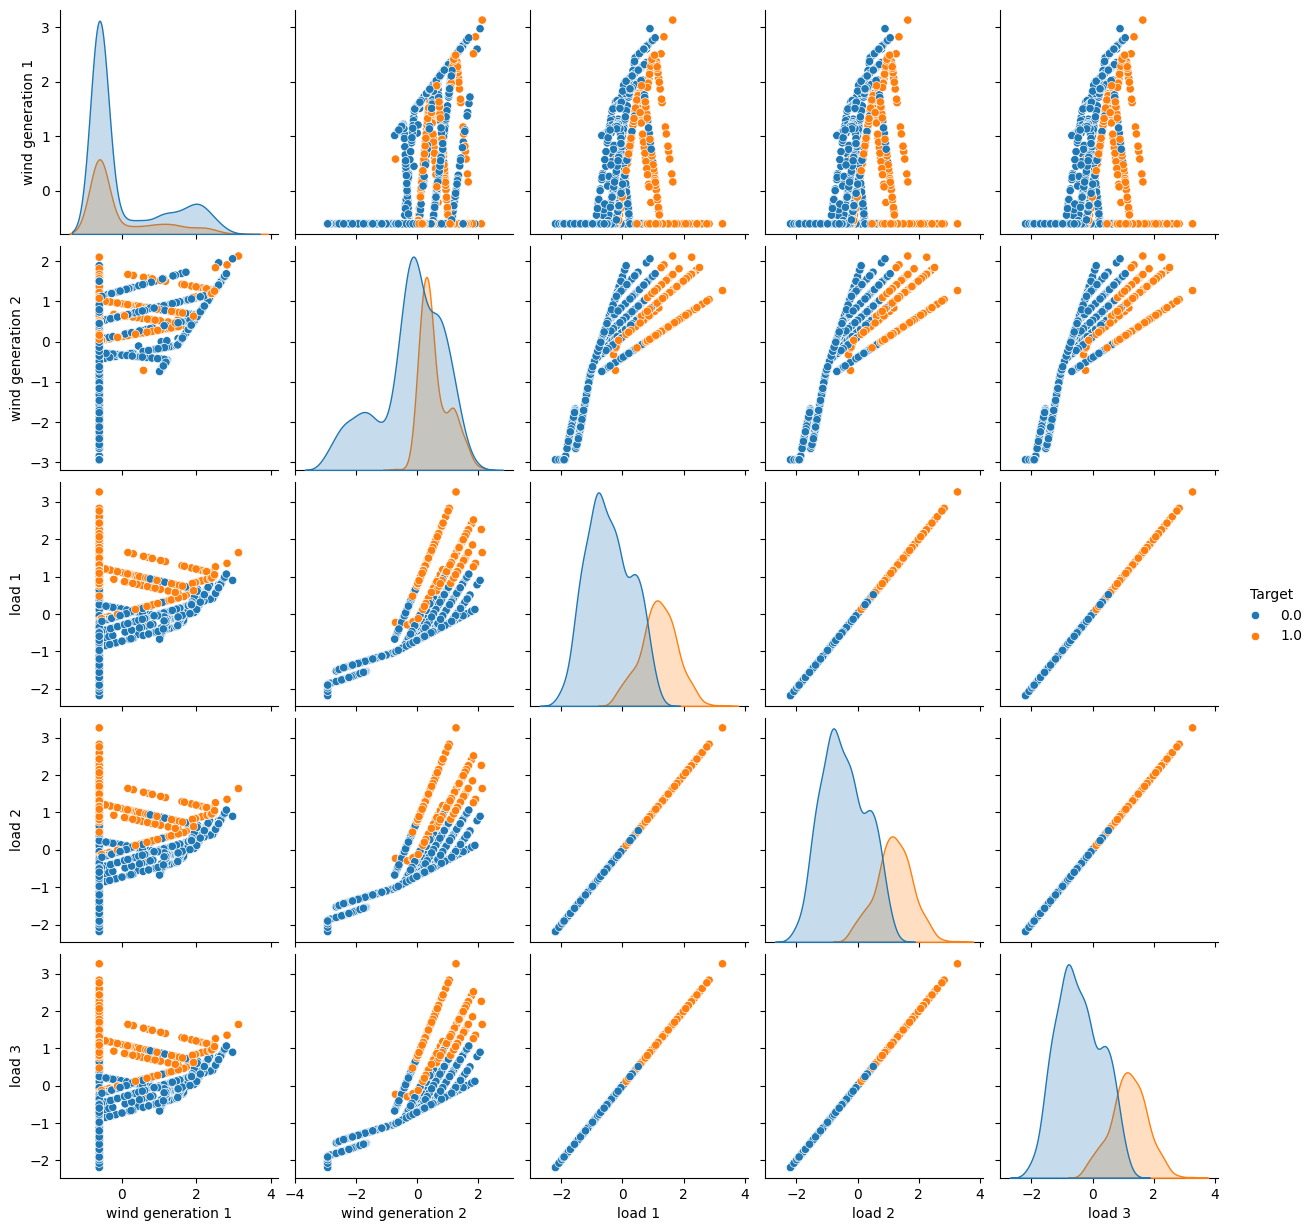

In [ ]:
df = pd.DataFrame(features, columns=['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3'])
df['Target'] = y_train["G2"]
sns.pairplot(df, hue='Target')

##### 3-D Plot